In [1]:
#libraries needed
!pip install snscrape
!pip install textblob
!pip install emot
!pip install dask
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from dask import dataframe as df1

import nltk
#nltk.download('stopwords')#run once and comment out
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

lemmatizer = WordNetLemmatizer()

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

In [2]:
# Get Tweets with the keyword Covid or pandemic or Covid-19
covid_scraper = sntwitter.TwitterSearchScraper('((Covid OR Covid-19 OR Covid19) AND (mask OR social distancing OR isolation OR quarantine)) near:"Toronto" since:2021-01-01 until:2022-12-31 lang:"en"')
print(type(covid_scraper))
# Display the data from the first tweet
for covid_tweet in covid_scraper.get_items():
   break
covid_tweet

<class 'snscrape.modules.twitter.TwitterSearchScraper'>


Tweet(url='https://twitter.com/pouchbaby/status/1608748144480878597', date=datetime.datetime(2022, 12, 30, 8, 53, 41, tzinfo=datetime.timezone.utc), rawContent='Nice plain language explanation for the risk of not masking. In my house now each family member (except me) has had Covid at different times. Nobody else got it from them here or anywhere we know of. We do mask. We quarantine. We rapid test. Out After 13 days when negative again.', renderedContent='Nice plain language explanation for the risk of not masking. In my house now each family member (except me) has had Covid at different times. Nobody else got it from them here or anywhere we know of. We do mask. We quarantine. We rapid test. Out After 13 days when negative again.', id=1608748144480878597, user=User(username='pouchbaby', id=22322274, displayname='Anita Szigeti', rawDescription="I'm a lawyer and a Mom. Obsessed with coffee and baseball. Superpowers: fluent in Hungarian & dog breeds. Also fluent in mental health law, ci

In [3]:
data = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper
    ('(mask OR distancing OR isolation) in: ("Toronto" OR "Montréal" OR "Vancouver" OR "Calgary" OR "Edmonton" OR "Ottawa" OR "Winnipeg" OR "Québec" OR "Hamilton" OR "Waterloo") since:2021-01-01 until:2022-12-31 lang:"en"').get_items()):
    if i>45000:
        break
    else:
        data.append([tweet.user.username, tweet.date, tweet.rawContent, tweet.likeCount, tweet.user.followersCount, tweet.user.friendsCount, tweet.replyCount, tweet.retweetCount, tweet.quoteCount, tweet.hashtags])
df = pd.DataFrame(data, columns = ["User", "Date Created", "Tweet", "Likes", "Followers", "Friends", "Reply","Retweet","Quote","Hashtags"])
#write the resulting raw data in a csv
df.to_csv('~/Desktop/Twitter_New/raw_tweet_30K_interventions_21_22.csv')
df

,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags
0,HSans,2022-12-30 23:42:46+00:00,"Here in #Québec, #Canada we've had this rule i...",0,2335,4527,0,0,0,"[Québec, Canada, SpecialCircumstances, WeShall..."
1,Randi_RLB,2022-12-30 23:11:27+00:00,"@DrAGrace_cyhtt ""Alberta's education minister ...",0,1531,2204,0,0,0,None
2,Golden_Pup,2022-12-30 22:51:45+00:00,November 18\n\nJust three days after defying a...,196,39775,584,3,23,1,None
3,EnigmaMachine8,2022-12-30 19:14:24+00:00,@shogun17761 @Katheri58113861 @kirkJK04 @jeanp...,0,2957,3137,0,0,0,None
4,Cognisant2000,2022-12-30 18:59:47+00:00,@GMMalliet Agree. We always wear a mask in enc...,0,2037,1713,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...
35627,SanjayB_yyz,2021-01-01 01:28:41+00:00,#CNNNYE Great way to end what has been a rough...,0,5,47,0,0,0,[CNNNYE]
35628,PeteJolicoeur,2021-01-01 01:04:25+00:00,To this day I cannot tell you what Rip Hamilto...,0,596,1198,0,0,0,None
35629,OttawaDreamCafe,2021-01-01 00:43:30+00:00,BREAKING NEWS: #bonneannee2021 #NewYear ELVIS ...,3,583,2354,0,3,0,"[bonneannee2021, NewYear, Ottawa, mask]"
35630,UberTumbleweed,2021-01-01 00:23:29+00:00,Hey @sobeys how come employees at your Newcast...,0,160,202,1,0,0,None


In [6]:
#Data preprocessing
eng_stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())
#nltk.download('punkt') #comment out after download
#nltk.download('wordnet') #comment out after download
#nltk.download('omw-1.4') #comment out after download

#Function to preprocess tweets
def ProcessedTweets(text):
    text = text.lower() #convert words to lower case
    
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text).split()) #remove @ and links
    
    text = re.sub(r'\@\w+|\#\w+|\d+','', text) #remove repeated characters
    
    punct = str.maketrans('','',string.punctuation+string.digits) #remove punctuation and numbers
    text = text.translate(punct)
    
    tokens = word_tokenize(text) # tokenizing words and removing stop words from teh tweet text
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    
    lemmatizer = WordNetLemmatizer() # lemmmatizing words
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    
    return text

In [8]:
#Generate a new column called 'Processed Tweets' by applying ProcessedTweets function to the 'Tweet' Column
df = pd.read_csv('~/Desktop/Twitter_New/raw_tweet_30K_interventions_21_22.csv')
df['Processed Tweets'] = df['Tweet'].apply(ProcessedTweets)
df.to_csv('~/Desktop/Twitter_New/prcessed_tweet_30K_interventions_21_22.csv')
df

,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags,Processed Tweets
0,0,HSans,2022-12-30 23:42:46+00:00,"Here in #Québec, #Canada we've had this rule i...",0,2335,4527,0,0,0,"['Québec', 'Canada', 'SpecialCircumstances', '...",weve rule place couple month like almost every...
1,1,Randi_RLB,2022-12-30 23:11:27+00:00,"@DrAGrace_cyhtt ""Alberta's education minister ...",0,1531,2204,0,0,0,NaN,cyhtt alberta education minister intervene w m...
2,2,Golden_Pup,2022-12-30 22:51:45+00:00,November 18\n\nJust three days after defying a...,196,39775,584,3,23,1,NaN,november three day defying sanity pleading ont...
3,3,EnigmaMachine8,2022-12-30 19:14:24+00:00,@shogun17761 @Katheri58113861 @kirkJK04 @jeanp...,0,2957,3137,0,0,0,NaN,youre trying convince person car take mask eve...
4,4,Cognisant2000,2022-12-30 18:59:47+00:00,@GMMalliet Agree. We always wear a mask in enc...,0,2037,1713,0,0,0,NaN,agree always wear mask enclosed space one time...
...,...,...,...,...,...,...,...,...,...,...,...,...
35627,35627,SanjayB_yyz,2021-01-01 01:28:41+00:00,#CNNNYE Great way to end what has been a rough...,0,5,47,0,0,0,['CNNNYE'],great way end rough year hanging amp guy aweso...
35628,35628,PeteJolicoeur,2021-01-01 01:04:25+00:00,To this day I cannot tell you what Rip Hamilto...,0,596,1198,0,0,0,NaN,day tell rip hamilton look like without includ...
35629,35629,OttawaDreamCafe,2021-01-01 00:43:30+00:00,BREAKING NEWS: #bonneannee2021 #NewYear ELVIS ...,3,583,2354,0,3,0,"['bonneannee2021', 'NewYear', 'Ottawa', 'mask']",breaking news elvis seen walking social distan...
35630,35630,UberTumbleweed,2021-01-01 00:23:29+00:00,Hey @sobeys how come employees at your Newcast...,0,160,202,1,0,0,NaN,hey come employee newcastle store edmonton wor...


In [9]:
#Add a column converting date and time to date only
from datetime import datetime
from email.utils import mktime_tz, parsedate_tz

# dtime = tweet['created_at']
dtime = '2022-01-01 00:05:15+00:00'
new_datetime = datetime.strftime(datetime.strptime(dtime,'%Y-%m-%d %H:%M:%S+00:00'), '%Y-%m-%d')
print((new_datetime))

# Function to convert date
def ConvertDate(dt):
    new_date = datetime.strftime(datetime.strptime(str(dt),'%Y-%m-%d %H:%M:%S+00:00'), '%Y-%m-%d')
    return new_date

2022-01-01


In [10]:
df['Date'] = df['Date Created'].apply(ConvertDate)
df.to_csv('~/Desktop/Twitter_New/prcessed_tweet_date_30K_interventions_21_22.csv')

In [11]:
df2 = pd.read_csv('~/Desktop/Twitter_New/prcessed_tweet_date_30K_interventions_21_22.csv')
df2

,Unnamed: 0.1,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags,Processed Tweets,Date
0,0,0,HSans,2022-12-30 23:42:46+00:00,"Here in #Québec, #Canada we've had this rule i...",0,2335,4527,0,0,0,"['Québec', 'Canada', 'SpecialCircumstances', '...",weve rule place couple month like almost every...,2022-12-30
1,1,1,Randi_RLB,2022-12-30 23:11:27+00:00,"@DrAGrace_cyhtt ""Alberta's education minister ...",0,1531,2204,0,0,0,NaN,cyhtt alberta education minister intervene w m...,2022-12-30
2,2,2,Golden_Pup,2022-12-30 22:51:45+00:00,November 18\n\nJust three days after defying a...,196,39775,584,3,23,1,NaN,november three day defying sanity pleading ont...,2022-12-30
3,3,3,EnigmaMachine8,2022-12-30 19:14:24+00:00,@shogun17761 @Katheri58113861 @kirkJK04 @jeanp...,0,2957,3137,0,0,0,NaN,youre trying convince person car take mask eve...,2022-12-30
4,4,4,Cognisant2000,2022-12-30 18:59:47+00:00,@GMMalliet Agree. We always wear a mask in enc...,0,2037,1713,0,0,0,NaN,agree always wear mask enclosed space one time...,2022-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35627,35627,35627,SanjayB_yyz,2021-01-01 01:28:41+00:00,#CNNNYE Great way to end what has been a rough...,0,5,47,0,0,0,['CNNNYE'],great way end rough year hanging amp guy aweso...,2021-01-01
35628,35628,35628,PeteJolicoeur,2021-01-01 01:04:25+00:00,To this day I cannot tell you what Rip Hamilto...,0,596,1198,0,0,0,NaN,day tell rip hamilton look like without includ...,2021-01-01
35629,35629,35629,OttawaDreamCafe,2021-01-01 00:43:30+00:00,BREAKING NEWS: #bonneannee2021 #NewYear ELVIS ...,3,583,2354,0,3,0,"['bonneannee2021', 'NewYear', 'Ottawa', 'mask']",breaking news elvis seen walking social distan...,2021-01-01
35630,35630,35630,UberTumbleweed,2021-01-01 00:23:29+00:00,Hey @sobeys how come employees at your Newcast...,0,160,202,1,0,0,NaN,hey come employee newcastle store edmonton wor...,2021-01-01


In [12]:
# Sentiment Analysis
import textblob
from textblob import TextBlob

# Function for polarity score
# Polarity is the output that lies between [-1,1], 
# where -1 refers to negative sentiment and +1 refers to positive sentiment. 
def polarity(text):
    return TextBlob(str(text)).sentiment.polarity

# Function for subjectivity score
# Subjectivity is the output that lies within [0,1] 
# and refers to personal opinions and judgments.
# If a sentence has high subjectivity i.e. close to 1, 
# It resembles that the text contains more personal opinion than factual information. 
def subjectivity(text):
    return TextBlob(str(text)).sentiment.subjectivity

In [13]:
# Get polarity of processed text
df2['Polarity'] = df2['Processed Tweets'].apply(polarity)
df2['Subjectivity'] = df2['Processed Tweets'].apply(subjectivity)
df2

,Unnamed: 0.1,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags,Processed Tweets,Date,Polarity,Subjectivity
0,0,0,HSans,2022-12-30 23:42:46+00:00,"Here in #Québec, #Canada we've had this rule i...",0,2335,4527,0,0,0,"['Québec', 'Canada', 'SpecialCircumstances', '...",weve rule place couple month like almost every...,2022-12-30,0.500000,0.500000
1,1,1,Randi_RLB,2022-12-30 23:11:27+00:00,"@DrAGrace_cyhtt ""Alberta's education minister ...",0,1531,2204,0,0,0,NaN,cyhtt alberta education minister intervene w m...,2022-12-30,-0.117262,0.577381
2,2,2,Golden_Pup,2022-12-30 22:51:45+00:00,November 18\n\nJust three days after defying a...,196,39775,584,3,23,1,NaN,november three day defying sanity pleading ont...,2022-12-30,0.000000,0.000000
3,3,3,EnigmaMachine8,2022-12-30 19:14:24+00:00,@shogun17761 @Katheri58113861 @kirkJK04 @jeanp...,0,2957,3137,0,0,0,NaN,youre trying convince person car take mask eve...,2022-12-30,0.000000,1.000000
4,4,4,Cognisant2000,2022-12-30 18:59:47+00:00,@GMMalliet Agree. We always wear a mask in enc...,0,2037,1713,0,0,0,NaN,agree always wear mask enclosed space one time...,2022-12-30,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35627,35627,35627,SanjayB_yyz,2021-01-01 01:28:41+00:00,#CNNNYE Great way to end what has been a rough...,0,5,47,0,0,0,['CNNNYE'],great way end rough year hanging amp guy aweso...,2021-01-01,0.600000,0.830000
35628,35628,35628,PeteJolicoeur,2021-01-01 01:04:25+00:00,To this day I cannot tell you what Rip Hamilto...,0,596,1198,0,0,0,NaN,day tell rip hamilton look like without includ...,2021-01-01,0.000000,0.000000
35629,35629,35629,OttawaDreamCafe,2021-01-01 00:43:30+00:00,BREAKING NEWS: #bonneannee2021 #NewYear ELVIS ...,3,583,2354,0,3,0,"['bonneannee2021', 'NewYear', 'Ottawa', 'mask']",breaking news elvis seen walking social distan...,2021-01-01,0.116667,0.133333
35630,35630,35630,UberTumbleweed,2021-01-01 00:23:29+00:00,Hey @sobeys how come employees at your Newcast...,0,160,202,1,0,0,NaN,hey come employee newcastle store edmonton wor...,2021-01-01,0.000000,0.000000


In [14]:
df2.to_csv('~/Desktop/Twitter_New/date_polarity_subjectivity_30K_interventions_21_22.csv')

In [15]:
# Individual influence score
# It is computed based on the number of followers
def IndividualInfluence(n_followers):
    if n_followers > 10000:
        x = 4
    elif n_followers > 1000:
        x = 3
    elif n_followers > 100: 
        x = 2
    elif n_followers > 10: 
        x = 1
    else:
        x = 0
    return x

In [16]:
# Response effect score
# It is computed based on the number of likes, replies, and retweets
def ResponseEffect(n_likes, n_replies, n_retweets):
    if n_likes >100:
        a=3
    elif n_likes >10:
        a=2
    elif n_likes >0: 
        a=1
    else:
        a=0   
    if n_replies >100:
        b=3
    elif n_replies >10:
        b=2
    elif n_replies >0: 
        b=1
    else:
        b=0
    if n_retweets >100:
        c=3
    elif n_retweets >10:
        c=2
    elif n_retweets >0: 
        c=1
    else:
        c=0   
    return (a+b+c)/3

#Separate function for each category
def LikeEffect(n_likes):
    if n_likes >100:
        a=3
    elif n_likes >10:
        a=2
    elif n_likes >0: 
        a=1
    else:
        a=0 
    return a

def ReplyEffect(n_replies):
    if n_replies >100:
        b=3
    elif n_replies >10:
        b=2
    elif n_replies >0: 
        b=1
    else:
        b=0
    return b

def RetweetEffect(n_retweets):
    if n_retweets >100:
        c=3
    elif n_retweets >10:
        c=2
    elif n_retweets >0: 
        c=1
    else:
        c=0   
    return c

In [17]:
# assign subjectivity level a category
def SubjectiveLevel(subjectivity_score):
    if subjectivity_score <0.25:
        d=1
    elif subjectivity_score <0.5:
        d=2
    elif subjectivity_score <0.75: 
        d=3
    else:
        d=4  
    return d

In [18]:
df3 = pd.read_csv('~/Desktop/Twitter_New/date_polarity_subjectivity_30K_interventions_21_22.csv')
df3['Like Effect'] = df3["Likes"].apply(LikeEffect)
df3['Reply Effect'] = df3["Reply"].apply(ReplyEffect)
df3['Retweet Effect'] = df3["Retweet"].apply(RetweetEffect)
df3['Individual Influence'] = df3['Followers'].apply(IndividualInfluence)
df3['Response Effect'] = df3.apply(lambda df3: ResponseEffect(df3["Likes"],df3["Reply"],df3["Retweet"]),axis=1)
df3['Subjective Level'] = df3["Subjectivity"].apply(SubjectiveLevel)
df3
df3.to_csv('~/Desktop/Twitter_New/individualinf_repsonseeff_30K_interventions_21_22.csv')

In [19]:
df3

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,...,Processed Tweets,Date,Polarity,Subjectivity,Like Effect,Reply Effect,Retweet Effect,Individual Influence,Response Effect,Subjective Level
0,0,0,0,HSans,2022-12-30 23:42:46+00:00,"Here in #Québec, #Canada we've had this rule i...",0,2335,4527,0,...,weve rule place couple month like almost every...,2022-12-30,0.500000,0.500000,0,0,0,3,0.000000,3
1,1,1,1,Randi_RLB,2022-12-30 23:11:27+00:00,"@DrAGrace_cyhtt ""Alberta's education minister ...",0,1531,2204,0,...,cyhtt alberta education minister intervene w m...,2022-12-30,-0.117262,0.577381,0,0,0,3,0.000000,3
2,2,2,2,Golden_Pup,2022-12-30 22:51:45+00:00,November 18\n\nJust three days after defying a...,196,39775,584,3,...,november three day defying sanity pleading ont...,2022-12-30,0.000000,0.000000,3,1,2,4,2.000000,1
3,3,3,3,EnigmaMachine8,2022-12-30 19:14:24+00:00,@shogun17761 @Katheri58113861 @kirkJK04 @jeanp...,0,2957,3137,0,...,youre trying convince person car take mask eve...,2022-12-30,0.000000,1.000000,0,0,0,3,0.000000,4
4,4,4,4,Cognisant2000,2022-12-30 18:59:47+00:00,@GMMalliet Agree. We always wear a mask in enc...,0,2037,1713,0,...,agree always wear mask enclosed space one time...,2022-12-30,0.000000,0.000000,0,0,0,3,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35627,35627,35627,35627,SanjayB_yyz,2021-01-01 01:28:41+00:00,#CNNNYE Great way to end what has been a rough...,0,5,47,0,...,great way end rough year hanging amp guy aweso...,2021-01-01,0.600000,0.830000,0,0,0,0,0.000000,4
35628,35628,35628,35628,PeteJolicoeur,2021-01-01 01:04:25+00:00,To this day I cannot tell you what Rip Hamilto...,0,596,1198,0,...,day tell rip hamilton look like without includ...,2021-01-01,0.000000,0.000000,0,0,0,2,0.000000,1
35629,35629,35629,35629,OttawaDreamCafe,2021-01-01 00:43:30+00:00,BREAKING NEWS: #bonneannee2021 #NewYear ELVIS ...,3,583,2354,0,...,breaking news elvis seen walking social distan...,2021-01-01,0.116667,0.133333,1,0,1,2,0.666667,1
35630,35630,35630,35630,UberTumbleweed,2021-01-01 00:23:29+00:00,Hey @sobeys how come employees at your Newcast...,0,160,202,1,...,hey come employee newcastle store edmonton wor...,2021-01-01,0.000000,0.000000,0,1,0,2,0.333333,1


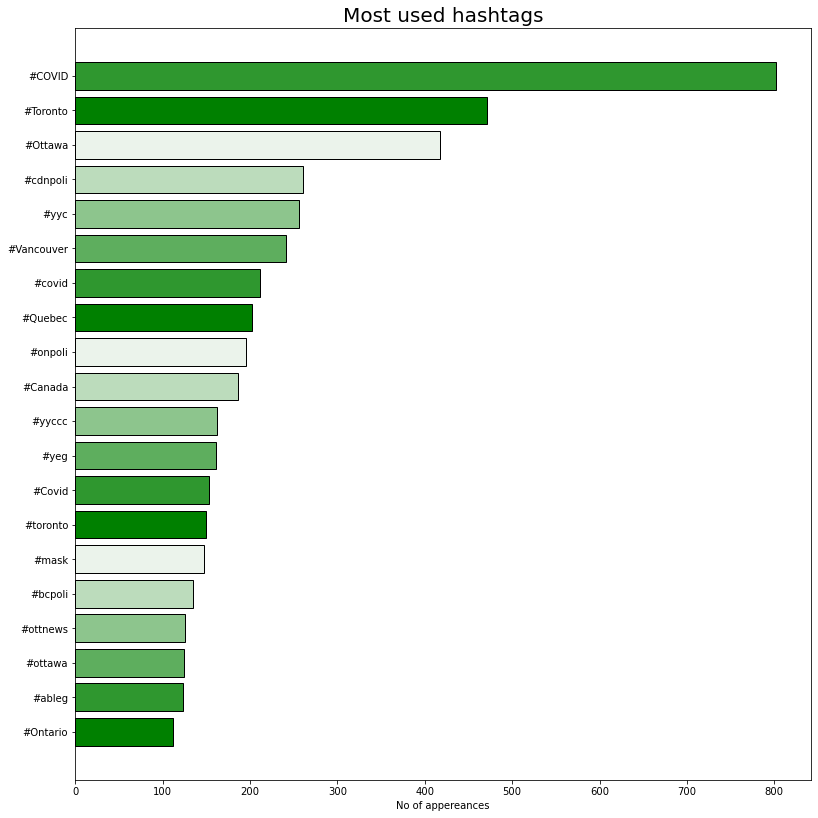

In [20]:
# Hashtag Analysis
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(df3['Tweet'].apply(hashtag_pattern.findall))
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]
#Separating the hashtags and their values into two different lists
hashtag_ordered_values = []
hashtag_ordered_keys = []
#Pick the 20 most used hashtags to plot
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])
    
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = sns.light_palette("green", reverse=True), edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("No of appereances")
ax.set_title("Most used hashtags", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()